# Classify B-ALL

- After every kernel restart rerun "Core"
- It's best to restart after you run a training process

## Core (Always run)

In [ ]:
%%sql


Imports

In [70]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import time
import os

import shap
import optuna

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

Global Variables

In [81]:
start_time = time.time()

path_to_data = "data/"

### Preprocess

Load Datasets

In [82]:
df_b_all = pd.read_parquet(f"{path_to_data}B_ALL.pq")
df_all = pd.read_parquet(f"{path_to_data}ALL.pq")

#### Merging

In [83]:
b_all_length = len(df_b_all.columns.drop(['gene_name', 'gene_type']))
all_length = len(df_all.columns.drop(['gene_name', 'gene_type']))

total_length = b_all_length + all_length

df_b_all_filtered = df_b_all[df_b_all['gene_type'] == 'protein_coding']
df_all_filtered = df_all[df_all['gene_type'] == 'protein_coding']

df_b_all_filtered = df_b_all_filtered.drop(['gene_name', 'gene_type'], axis=1)
df_all_filtered = df_all_filtered.drop(['gene_name', 'gene_type'], axis=1)

df_b_all_filtered = df_b_all_filtered.fillna(0).select_dtypes(include='number').T
df_all_filtered = df_all_filtered.fillna(0).select_dtypes(include='number').T

print("Filtered B-ALL length:", len(df_b_all_filtered))
print("Filtered ALL length:", len(df_all_filtered))

combined_df = pd.concat([df_b_all_filtered, df_all_filtered], axis=0)

combined_df['condition'] = [1] * len(df_all_filtered) + [0] * len(df_b_all_filtered)

if (len(df_b_all_filtered) + len(df_all_filtered)) != combined_df.shape[0]:
    print(f"Expected number of rows: {len(df_b_all_filtered) + len(df_all_filtered)}, Actual number of rows: {combined_df.shape[0]}")
    raise ValueError("The number of rows in the combined DataFrame does not match the sum of B-ALL and B-ALL Healthy lengths.")

Filtered B-ALL length: 1182
Filtered ALL length: 568


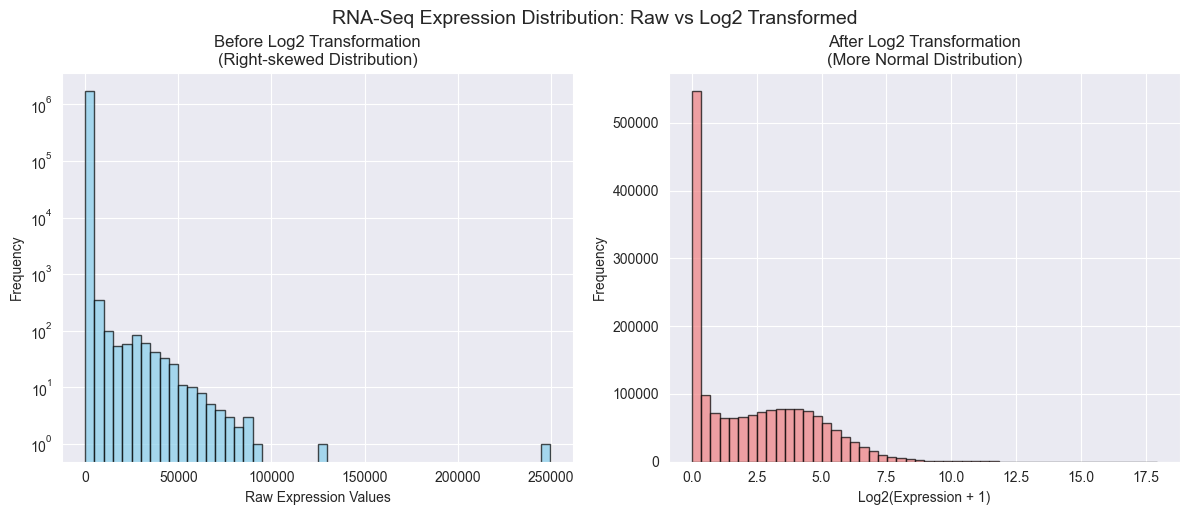

In [84]:
np.random.seed(42)
sample_genes = np.random.choice(combined_df.columns, size=1000, replace=False)
sample_data = combined_df[sample_genes]

# Flatten the data for plotting
raw_values = sample_data.values.flatten()
log2_values = np.log2(sample_data + 1).values.flatten()

# Create side-by-side histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw expression distribution
ax1.hist(raw_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Raw Expression Values')
ax1.set_ylabel('Frequency')
ax1.set_title('Before Log2 Transformation\n(Right-skewed Distribution)')
ax1.set_yscale('log')  # Use log scale for y-axis due to extreme skew

# Log2 transformed distribution
ax2.hist(log2_values, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.set_xlabel('Log2(Expression + 1)')
ax2.set_ylabel('Frequency')
ax2.set_title('After Log2 Transformation\n(More Normal Distribution)')

plt.tight_layout()
plt.suptitle('RNA-Seq Expression Distribution: Raw vs Log2 Transformed', 
             fontsize=14, y=1.02)
plt.show()

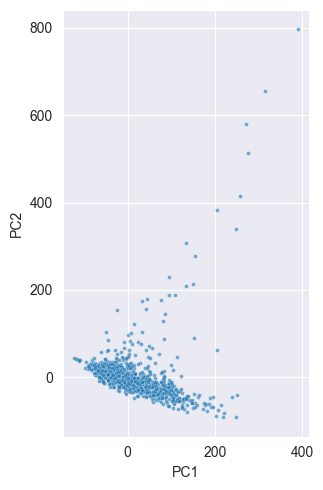

In [85]:
expr = combined_df.copy()

expr_z = StandardScaler().fit_transform(expr)

pca = PCA(n_components=2, random_state=0)
coords = pca.fit_transform(expr_z)

pc_df = pd.DataFrame(coords, columns=['PC1', 'PC2'], index=expr.index)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pc_df, x='PC1', y='PC2', s=8, alpha=0.6)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

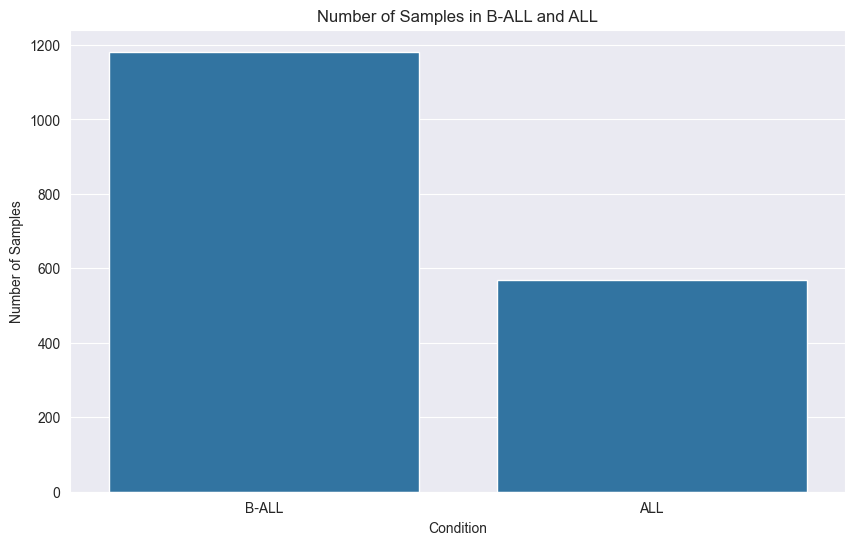

In [86]:
plt.figure(figsize=(10, 6))
sns.barplot(x=['B-ALL', 'ALL'], y=[len(df_b_all_filtered), len(df_all_filtered)])
plt.title('Number of Samples in B-ALL and ALL')
plt.ylabel('Number of Samples')
plt.xlabel('Condition')
plt.show()

Labeling

In [87]:
y = combined_df['condition']  # Use the 'condition' column as the target variable

combined_df.drop(columns=['condition'], inplace=True)  # Drop the 'condition' column for normalization

Main

Log2 Normalizing

In [88]:
merged_df_normalized = np.log2(combined_df + 1)  # Log2 transformation

In [89]:
merged_df_normalized.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

Scaler

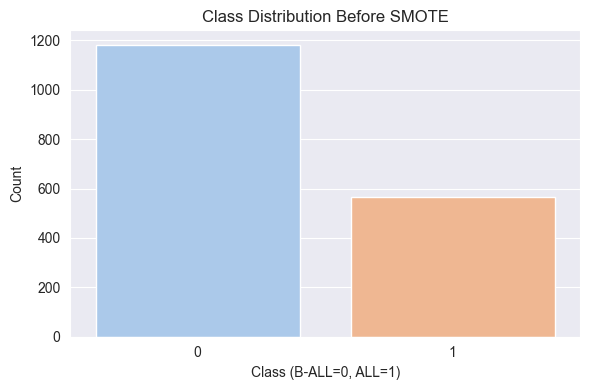

In [90]:
# Plot class distribution before SMOTE (using original y)
counts_before = pd.Series(y).value_counts().sort_index()
plt.figure(figsize=(6,4))
sns.barplot(x=counts_before.index, y=counts_before.values, palette="pastel")
plt.xlabel("Class (B-ALL=0, ALL=1)")
plt.ylabel("Count")
plt.title("Class Distribution Before SMOTE")
plt.tight_layout()
plt.show()

Optuna

In [118]:
trial_results = {"xgboost": [], "random_forest": [], "logistic_regression": []}

# Callback to record each trial's model type and its score.
def record_trial_callback(study, trial):
    classifier = trial.params.get("classifier")
    trial_results[classifier].append((trial.number, trial.value))

def optimize_classifier(x, y, n_trials=20):
    def objective(trial):
        k = trial.suggest_int("k", 20, merged_df_normalized.shape[0] / 4)  # k is capped at 1/4th of features.
        classifier_choice = trial.suggest_categorical("classifier", ["xgboost", "random_forest", "logistic_regression"])

        if classifier_choice == "xgboost":
            params = {
                "max_depth": trial.suggest_int("max_depth", 3, 15),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "tree_method": "hist",
                "objective": "binary:logistic",
                "eval_metric": "auc",
            }
            model = xgb.XGBClassifier(**params, use_label_encoder=False, verbosity=0)
        elif classifier_choice == "random_forest":
            params = {
                "n_estimators": trial.suggest_int("n_estimators_rf", 50, 300),
                "max_depth": trial.suggest_int("max_depth_rf", 3, 15),
                "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            }
            model = RandomForestClassifier(**params, random_state=42, class_weight="balanced")
        elif classifier_choice == "logistic_regression":
            c_value = trial.suggest_float("C", 1e-4, 1e2, log=True)
            model = LogisticRegression(C=c_value, solver="liblinear",
                                       random_state=42, class_weight="balanced", max_iter=1000)
        else:
            raise ValueError("Unsupported classifier selected.")

        pipeline = Pipeline([
            # ('smote', SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)),
            ("scaler", StandardScaler()),
            ("select_kbest", SelectKBest(score_func=f_classif, k=k)),
            ("classifier", model)
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(pipeline, x, y, scoring="roc_auc", cv=cv).mean()

        if np.isnan(score):
            print("NaN score encountered, returning a low score.")
            return 0.0
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, callbacks=[record_trial_callback])

    print("Best parameters:", study.best_params)
    print("Best ROC-AUC:", study.best_value)
    return study

# Run the optimization.
study_result = optimize_classifier(merged_df_normalized, y, n_trials=5)

[I 2025-06-23 17:42:04,330] A new study created in memory with name: no-name-245ac878-91f3-4e29-a166-a7e9d4d4639c
[W 2025-06-23 17:42:08,819] Trial 0 failed with parameters: {'k': 206, 'classifier': 'xgboost', 'max_depth': 14, 'learning_rate': 0.21403414295452336, 'n_estimators': 73} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\ravan\Documents\GitHub\URBAN_MOBILITY_backend_system\.venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ravan\AppData\Local\Temp\ipykernel_59132\2603025482.py", line 46, in objective
    score = cross_val_score(pipeline, x, y, scoring="roc_auc", cv=cv).mean()
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ravan\Documents\GitHub\URBAN_MOBILITY_backend_system\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*a

KeyboardInterrupt: 

Apply Optuna result

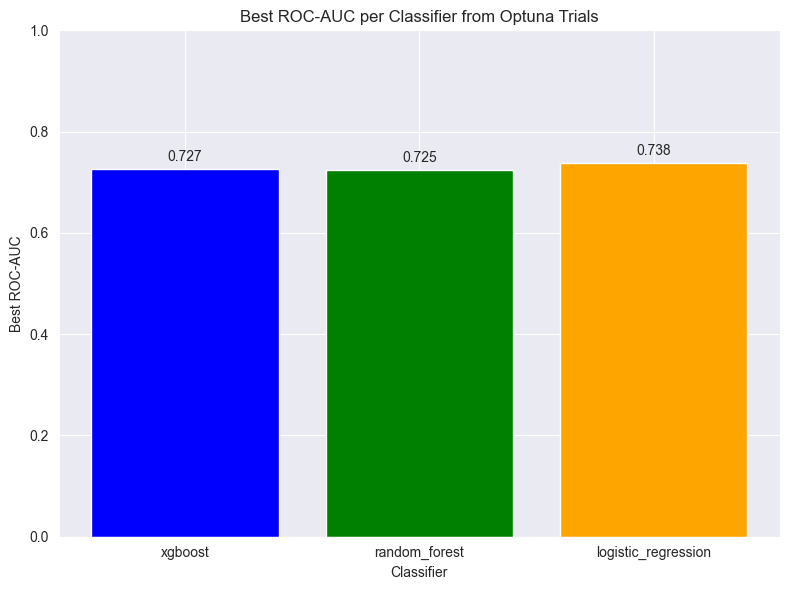

Plot saved to plots\best_classifier_comparison.png


In [96]:
best_scores = {}
for clf in trial_results:
    if trial_results[clf]:
        best_trial = max(trial_results[clf], key=lambda t: t[1])
        best_scores[clf] = best_trial[1]
    else:
        best_scores[clf] = 0

models = list(best_scores.keys())
scores = [best_scores[m] for m in models]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, scores, color=['blue', 'green', 'orange'])
plt.ylabel("Best ROC-AUC")
plt.xlabel("Classifier")
plt.title("Best ROC-AUC per Classifier from Optuna Trials")
plt.ylim(0, 1)
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{score:.3f}', ha='center', va='bottom')

if not os.path.exists("plots"):
    os.makedirs("plots")

plot_path = os.path.join("plots", "best_classifier_comparison.png")
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")

Select K Best

In [106]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(
    merged_df_normalized, y, test_size=0.2, random_state=42, stratify=y
)

best_params = study_result.best_params

# apply smote
# smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)
# x_train, y_train = smote.fit_resample(x_train, y_train)

# Apply Standard Scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)

# Create the SelectKBest object
select_k_best = SelectKBest(score_func=f_classif, k=best_params["k"])

# Fit and transform the training data
x_train_selected = select_k_best.fit_transform(x_train, y_train)

# Get the selected feature names
# Note: merged_df_normalized should be your original feature matrix before scaling
selected_feature_indices = select_k_best.get_support(indices=True)
selected_feature_names = merged_df_normalized.columns[selected_feature_indices].tolist()

# Transform test data
x_test_selected = select_k_best.transform(x_test)

# Update your variables
x_train = x_train_selected
x_test = x_test_selected

Training

In [115]:
model = LogisticRegression(C=best_params["C"], random_state=42, solver="liblinear", max_iter=1000, class_weight="balanced")

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

y_proba = model.predict_proba(x_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC on test set: {roc_auc:.4f}")

ROC-AUC on test set: 0.7762


### Statistics and Plots

Confusion Matrix

<Figure size 800x600 with 0 Axes>

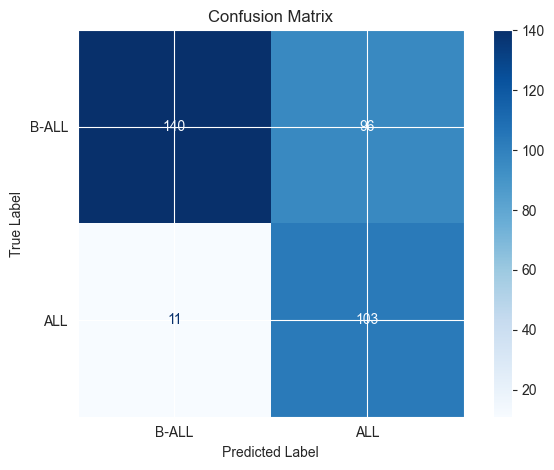

Confusion matrix saved to plots\confusion_matrix.png


In [111]:
# Create a confusion matrix please
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["B-ALL", "ALL"])

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

confusion_matrix_path = os.path.join("plots", "confusion_matrix.png")
plt.savefig(confusion_matrix_path)
plt.show()

print(f"Confusion matrix saved to {confusion_matrix_path}")

Precision recall curve

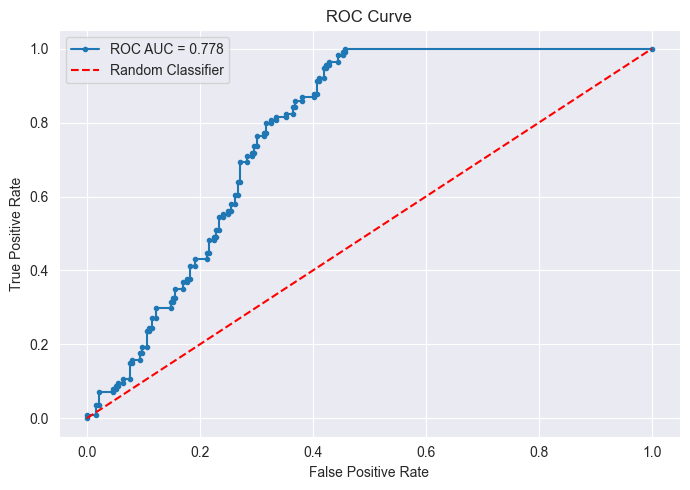

In [109]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, marker='.', label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

SHAP

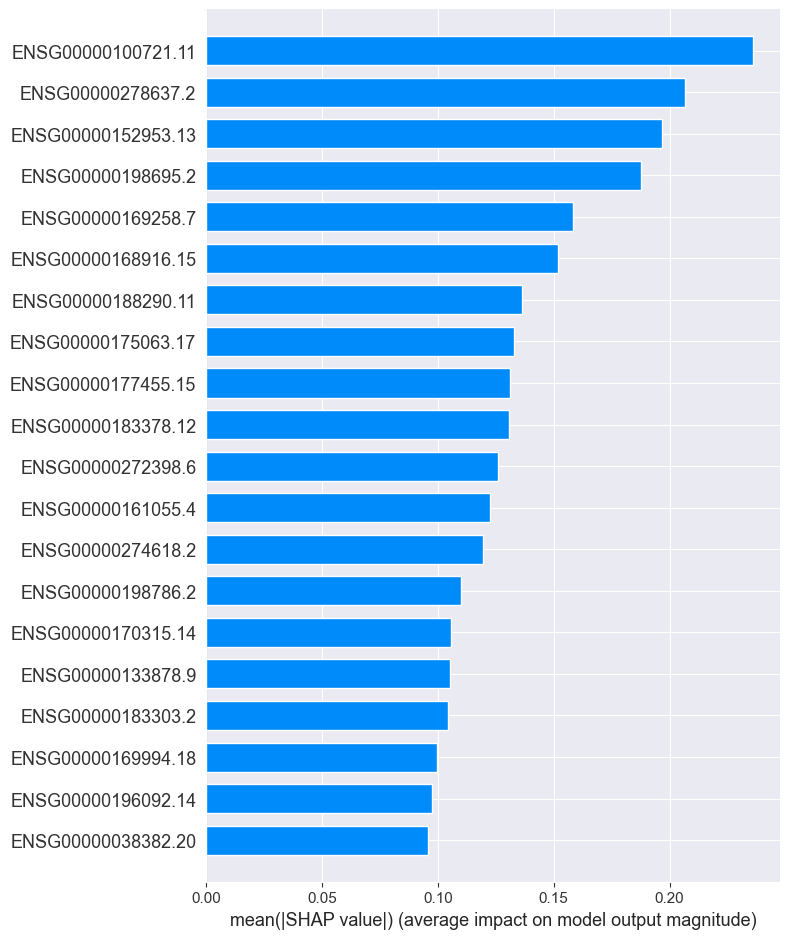

SHAP summary plot saved to plots\shap_summary_plot.png


In [117]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer.shap_values(x_test)

x_test_df = pd.DataFrame(x_test, columns=selected_feature_names)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, x_test_df, plot_type="bar", show=False)
plt.tight_layout()

shap_plot_path = os.path.join("plots", "shap_summary_plot.png")
plt.savefig(shap_plot_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"SHAP summary plot saved to {shap_plot_path}")